<a target="_blank" href="https://colab.research.google.com/github/amir-meshkini/protein_deltaG_classifier/blob/main/03_api.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# An easy-to-use API 

After training the model, now it's time to use it to predict the ΔG for some new sets of amino acid sequences.

The below cell contains a function that automates the prediction by taking a single sequence as input. 

The below function could be easily chanced to take multiple sequences at once, but here I decided to stick with the single input version of it. 

### First run the below cell

In [ ]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer, TFEsmModel


def sequence_to_deltaG():
    amino_acid_seq = input("The amino acid sequence (at least 20 one-word abbreviated characters):").upper()

    # checking if the input is OK
    aa_abbr = 'arndcqeghilkmfpstwyv' 
    valid_chars = [i.upper() for i in aa_abbr]

    for i in amino_acid_seq: 
        if i not in valid_chars: 
            raise ValueError('Your input contains non valid amino acid abbreviation(s), try again')
        
    print('----------------------------------------------------------------------------------------------------------------')
    print('Calculating the deltaG for the given sequence:')
    print(amino_acid_seq)
    print('----------------------------------------------------------------------------------------------------------------')

    # As in Notebook 01 
    print('Initializing the tokenizer... (1/6)')
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name) 

    print('Tokenizing... (2/6)')
    token = tokenizer(amino_acid_seq, return_tensors="tf", padding=True, truncation=True, max_length=1024)

    print('Initializing the EMS model...(3/6)')
    esm = TFEsmModel.from_pretrained(model_name) 

    print('Vectorizing...(4/6)')
    vector = esm(token, training=False)

    print('Embedding...(5/6)')
    token_embedding = vector.last_hidden_state
    attention_mask = token['attention_mask']
    mask = tf.cast(tf.expand_dims(attention_mask, -1), tf.float32)
    sum_embedding = tf.reduce_sum(token_embedding * mask, axis=1)
    sum_mask = tf.reduce_sum(mask, axis=1) 
    protein_vector = sum_embedding / tf.maximum(sum_mask, 1e-9)
    X = protein_vector.numpy() 

    # Loading the model that we obtained in notebook 02
    print('Loading the model...(6/6)')
    loaded_model = tf.keras.models.load_model('MODELS\model_8m_150K') # Change the directory if necessary

    # This dictionary is copied from the previous notebook
    label_dict = {0: '8 to 9', 1: '5 to 6', 2: '0 to 1', 3: '-4 to -3', 4: '3 to 4',
                  5: '4 to 5', 6: '1 to 2', 7: '12 to 13', 8: '-5 to -4', 9: '-2 to -1',
                  10: '10 to 11', 11: '11 to 12', 12: '-9 to -8', 13: '-7 to -6', 14: '-8 to -7',
                  15: '-10 to -9', 16: '13 to 14', 17: '-3 to -2', 18: '2 to 3', 19: '-6 to -5',
                  20: '9 to 10', 21: '7 to 8', 22: '15 to 16', 23: '14 to 15', 24: '6 to 7',
                  25: '-1 to 0'} 

    # Predicting and gathering some insights from the prediction
    prediction_probs = loaded_model.predict(X) 
    most_prob_labels = prediction_probs[0].argsort()[::-1][:3]
    class_list = [label_dict[i] for i in most_prob_labels] 
    class_list.append('Other') 
    weights = [prediction_probs[0][i]*100 for i in most_prob_labels] 
    weights.append(100-sum(weights))

    print('----------------------------------------------------------------------------------------------------------------')
    print(f'The deltaG value of the given sequence most likely lies between {class_list[0]} Kcal/mol with the confidence of {weights[0]:.1f}%')
    print('----------------------------------------------------------------------------------------------------------------') 
    print('Here is a pie chart of the next probable values:') 

    # Visualizing a little bit
    plt.figure(figsize=(6,6))
    plt.pie(weights, labels=class_list, autopct='%1.1f%%', shadow=True, 
            explode=(0.05,0.05,0.05,0.05)) 
    plt.title('Most probable values for deltaG (Kcal/mol)')
    plt.show() 

### Here, some sample sequences are provided to try out the model for yourselves. 

> **Note!** The below samples were not used at any stages of training and testing the model, so there shouldn't be any worries about data leakage. If you want more sample sequences you can download the [original PSPD dataset](https://huggingface.co/datasets/benchang323/protein-stability-prediction).

| **Amino acid sequence** | **Experimental value (Kcal/mol)** |
| --- | --- | 
|ELVLALYDYQEKSPREVTMKKGDILTLLNSTNKDIWKVEVNDRQGQVPASYVKKLD|-7.966|
|GGHPVTTQMVETVQNLAPNLHPEQIRYELENTGSVEEHVERYLRGDEFSFPP|-1.502|
|MQIFVKTVTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLAFAGKQLEDGRTLSDYNIQKESTLHLALR|7.960|
|LQLFIMTLTGKTFTVEMEPSDTIENLKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVL|15.277|
|SCYEILDVPRSASADDIKKAYRRKALQWHPDKNPDNKEFAEKKFKEVACAYEVLSDKHKREIYDR|2.476|
|MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGAQLEDGRTLSDYNIQKESTLHLV|12.922|
|ATNIVGKVKWYNSTKNFGFIEQDNAGGKDVFVHKSAVDAAGLHSLEEGQDVIFDLEEKQGKAYAVNLRIK|13.276|
|MQIFVKTATGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLMFAGKQLEDGRTLSDYNIQKESTLHLALR|9.231|
|LQLFIKTWTGKTFTVEMEPSDTIENLKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVL|12.524|
|PDFTLHWNGITIHFKGIDEEQFKHLRELLDRGVSLEELEELAKELIK|3.826|
|MQYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTQDDATKTRTVTE|-5.858|


### Run the below cell and give a sequence as input

----------------------------------------------------------------------------------------------------------------
Calculating the deltaG for the given sequence:
MQYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTQDDATKTRTVTE
----------------------------------------------------------------------------------------------------------------
Initializing the tokenizer... (1/6)


c:\Users\amesh\anaconda3\envs\cvproj\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing... (2/6)
Initializing the EMS model...(3/6)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFEsmModel: ['lm_head.dense.bias', 'esm.embeddings.position_embeddings.weight', 'esm.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFEsmModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFEsmModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFEsmModel were not initialized from the PyTorch model and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

Vectorizing...(4/6)
Embedding...(5/6)
Loading the model...(6/6)
1/1 [==============================] - 0s 74ms/step
----------------------------------------------------------------------------------------------------------------
The deltaG value of the given sequence most likely lies between -6 to -5 Kcal/mol with the confidence of 43.1%
----------------------------------------------------------------------------------------------------------------
Here is a pie chart of the next probable values:


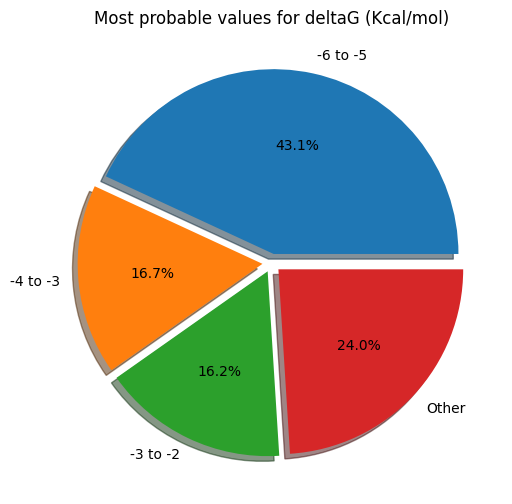

In [70]:
sequence_to_deltaG()